Epoch [1/10], Loss1: 2.2456, Loss2: 2.1286
Epoch [2/10], Loss1: 1.8529, Loss2: 1.8558
Epoch [3/10], Loss1: 1.4371, Loss2: 1.5635
Epoch [4/10], Loss1: 1.4100, Loss2: 1.2515
Epoch [5/10], Loss1: 0.9090, Loss2: 1.0381
Epoch [6/10], Loss1: 0.8835, Loss2: 0.8643
Epoch [7/10], Loss1: 0.8262, Loss2: 0.6418
Epoch [8/10], Loss1: 0.7735, Loss2: 0.4313
Epoch [9/10], Loss1: 0.4879, Loss2: 0.0665
Epoch [10/10], Loss1: 0.2757, Loss2: 0.1004
R2 Score Model1: 0.8051
R2 Score Model2: 0.9396


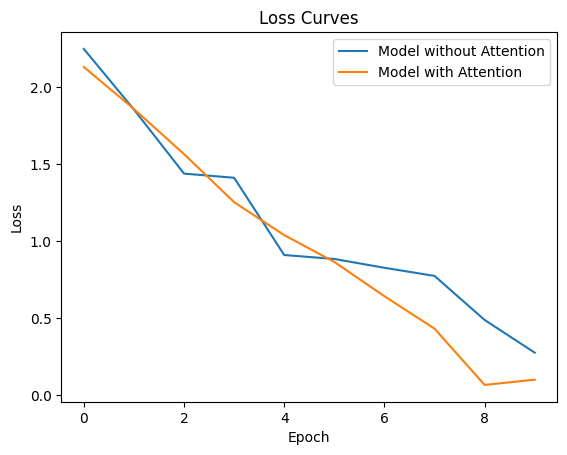

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate dummy data
def generate_data(num_samples, seq_len, vocab_size):
    data = []
    for _ in range(num_samples):
        src = [random.randint(1, vocab_size-1) for _ in range(seq_len)]
        tgt = src[::-1]  # Reverse the source sequence for the target
        data.append((src, tgt))
    return data

vocab_size = 20
seq_len = 10
num_samples = 1000
data = generate_data(num_samples, seq_len, vocab_size)

# Define dummy vocab (for demonstration purposes)
vocab = {str(i): i for i in range(vocab_size)}

class Seq2SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

dataset = Seq2SeqDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(1)
        H = hidden.repeat(max_len, 1, 1).transpose(0, 1)
        attn_energies = self.score(H, encoder_outputs)
        return torch.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedding = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedding)
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers, attention=None):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.attention = attention
        self.embedding = nn.Embedding(output_size, embed_size)
        self.lstm = nn.LSTM(hidden_size + embed_size if attention else embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell, encoder_outputs=None):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        if self.attention is not None:
            attn_weights = self.attention(hidden[-1], encoder_outputs)
            context = attn_weights.bmm(encoder_outputs)
            rnn_input = torch.cat((embedding, context), dim=2)
        else:
            rnn_input = embedding

        outputs, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        predictions = self.fc(outputs.squeeze(1))
        return predictions, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)

        encoder_outputs, hidden, cell = self.encoder(source)

        x = target[:, 0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell, encoder_outputs if self.decoder.attention else None)
            outputs[:, t, :] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess

        return outputs

# Initialize the models
input_size = vocab_size
output_size = vocab_size
embed_size = 256
hidden_size = 512
num_layers = 2

# Without Attention
encoder1 = Encoder(input_size, embed_size, hidden_size, num_layers).to(device)
decoder1 = Decoder(output_size, embed_size, hidden_size, num_layers).to(device)
model1 = Seq2Seq(encoder1, decoder1).to(device)

# With Attention
attention = Attention(hidden_size)
encoder2 = Encoder(input_size, embed_size, hidden_size, num_layers).to(device)
decoder2 = Decoder(output_size, embed_size, hidden_size, num_layers, attention).to(device)
model2 = Seq2Seq(encoder2, decoder2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Training loop
num_epochs = 10
losses1 = []
losses2 = []

for epoch in range(num_epochs):
    model1.train()
    model2.train()
    for i, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        # Train model without attention
        optimizer1.zero_grad()
        output1 = model1(src, tgt)
        output1 = output1[:, 1:].reshape(-1, output1.shape[2])
        tgt1 = tgt[:, 1:].reshape(-1)
        loss1 = criterion(output1, tgt1)
        loss1.backward()
        optimizer1.step()

        # Train model with attention
        optimizer2.zero_grad()
        output2 = model2(src, tgt)
        output2 = output2[:, 1:].reshape(-1, output2.shape[2])
        tgt2 = tgt[:, 1:].reshape(-1)
        loss2 = criterion(output2, tgt2)
        loss2.backward()
        optimizer2.step()

    losses1.append(loss1.item())
    losses2.append(loss2.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss1: {loss1.item():.4f}, Loss2: {loss2.item():.4f}')

# Calculate R2 score for both models
model1.eval()
model2.eval()
true_vals = []
preds1 = []
preds2 = []

with torch.no_grad():
    for i, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        output1 = model1(src, tgt)
        output1 = output1[:, 1:].reshape(-1, output1.shape[2])
        tgt1 = tgt[:, 1:].reshape(-1)
        pred1 = torch.argmax(output1, dim=1)
        
        output2 = model2(src, tgt)
        output2 = output2[:, 1:].reshape(-1, output2.shape[2])
        tgt2 = tgt[:, 1:].reshape(-1)
        pred2 = torch.argmax(output2, dim=1)
        
        true_vals.extend(tgt1.cpu().numpy())
        preds1.extend(pred1.cpu().numpy())
        preds2.extend(pred2.cpu().numpy())

r2_1 = r2_score(true_vals, preds1)
r2_2 = r2_score(true_vals, preds2)

print(f'R2 Score Model1: {r2_1:.4f}')
print(f'R2 Score Model2: {r2_2:.4f}')

# Plot loss curves
plt.plot(losses1, label='Model without Attention')
plt.plot(losses2, label='Model with Attention')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()
